# Imports

In [1]:
# Upload data on google drive and call it in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import pickle

In [4]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

# Data Loading & Pre-processing 

In [9]:
# copy data file into content in colab to be used 
!cp /content/drive/MyDrive/Sentiment_Analysis/data.zip /content 

In [10]:
# convert zip files to normal file so we can call its content 
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [11]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)




In [12]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
dataset

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


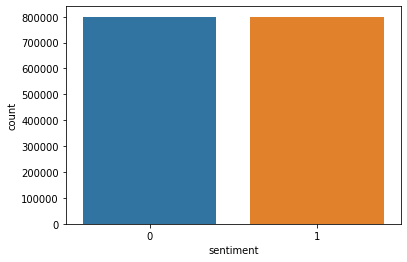

In [14]:
sns.countplot(dataset['sentiment'])

In [15]:
dataset.isnull().sum()

sentiment    0
text         0
dtype: int64

In [16]:
dataset.dtypes

sentiment     int64
text         object
dtype: object

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
def preprocess(textdata):
    processedText = []

    # Defining dictionary containing all emojis with their meanings.
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
    stopwords_english = stopwords.words('english')
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if (word not in stopwords_english):
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)

        
    return processedText

In [19]:
# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [23]:
t = time.time()
processed_text = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 154 seconds


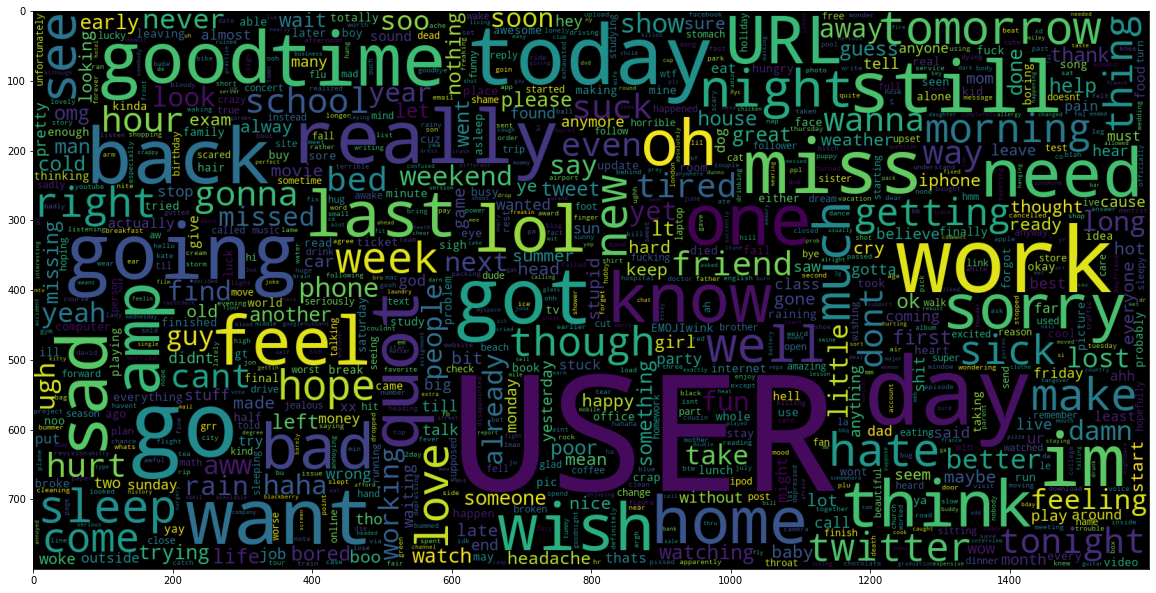

In [24]:
data_neg = processed_text[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [41]:
# feature extraction
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000)  # Convert a collection of raw documents to a matrix of TF-IDF features.
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  5000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
# Transform dictionary features into 2D feature matrix.
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Modeling & Evaluating 

In [43]:
models = [LogisticRegression(),MultinomialNB(),SGDClassifier(),CatBoostClassifier(),AdaBoostClassifier(),XGBClassifier(),GradientBoostingClassifier()]

In [44]:
for i in range(len(models)):
  model = models[i].fit(X_train,y_train)
  prediction = models[i].predict(X_test)
  acc = accuracy_score(y_test,prediction)
  print("accuracy of model",i,"is : ", acc)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of model 0 is :  0.775584375
accuracy of model 1 is :  0.761225
accuracy of model 2 is :  0.767046875


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.218631
0:	learn: 0.6745813	total: 3.95s	remaining: 1h 5m 47s
1:	learn: 0.6628085	total: 7.62s	remaining: 1h 3m 22s
2:	learn: 0.6543675	total: 11.1s	remaining: 1h 1m 41s
3:	learn: 0.6479562	total: 14.6s	remaining: 1h 46s
4:	learn: 0.6417591	total: 17.6s	remaining: 58m 31s
5:	learn: 0.6373541	total: 20.9s	remaining: 57m 42s
6:	learn: 0.6331398	total: 23.9s	remaining: 56m 27s
7:	learn: 0.6293321	total: 27s	remaining: 55m 42s
8:	learn: 0.6257603	total: 30s	remaining: 54m 58s
9:	learn: 0.6229525	total: 33.4s	remaining: 55m 4s
10:	learn: 0.6197720	total: 36.2s	remaining: 54m 15s
11:	learn: 0.6176867	total: 39.2s	remaining: 53m 46s
12:	learn: 0.6153674	total: 42.1s	remaining: 53m 19s
13:	learn: 0.6133992	total: 45.1s	remaining: 52m 55s
14:	learn: 0.6112573	total: 48s	remaining: 52m 30s
15:	learn: 0.6091549	total: 50.9s	remaining: 52m 11s
16:	learn: 0.6072030	total: 53.8s	remaining: 51m 52s
17:	learn: 0.6054686	total: 56.7s	remaining: 51m 31s
18:	learn: 0.6038608	total: 

In [45]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# c penalty sterngth 
# L1 absolute value  # L2 Square value

In [46]:
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [47]:
logreg_cv.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [48]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.7741625000000001


In [49]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1)

In [50]:
prediction = logreg2.predict(X_test)

In [51]:
accuracy_score(y_test,prediction)

0.775584375

In [52]:
file = open('Sentiment-LR.pickle','wb')
pickle.dump(logreg2, file)
file.close()

# Predication Function

In [80]:
def prdeiction_fun(sample_input):
    df = pd.DataFrame (sample_input, columns = ['text'])
    processed_text = preprocess(df)
    extracted_text = vectoriser.transform(processed_text)
    prediction_text = logreg2.predict(extracted_text)
    print(prediction_text)

In [81]:
test_input = ["Free Webinar on Big Data &amp; Data Science With Artificial Intelligence\n\nFill Google Form and Join USƒ?? https://t.co/sr7v4xSVYo"]

In [82]:
prdeiction_fun(test_input)

[1]


# PipeLine

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [89]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [108]:

logreg = Pipeline([
                   ('Vectorization', TfidfVectorizer()),
                ('Transformer', TfidfTransformer()),
                ('clf', LogisticRegression(C=1,penalty="l2")),
               ])
X_train, X_test, y_train, y_test = train_test_split(preprocess(text), sentiment,
                                                    test_size = 0.2, random_state = 0)
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy 0.77764375
